# Custom MLflow Model

In [7]:
import mlflow.pyfunc
import pandas as pd
import numpy as np

# A Mock Model Class
class SalesForecaster(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        # This is where you would load artifacts (e.g., .pkl files)
        # self.model = pickle.load(context.artifacts["model_path"])
        pass

    def predict(self, context, model_input):
        """
        Custom predict handles logic:
        Input: JSON/Dict with 'horizon'
        Output: Forecast DataFrame
        """
        h = model_input.get("h", [7])[0] # Get horizon
        
        # Mock logic: return random forecast
        return pd.DataFrame({
            "day": range(1, h+1),
            "forecast": np.random.rand(h) * 100
        })

# Save and Load (Simulation)
# In a real notebook, you would use mlflow.save_model(...)
my_model = SalesForecaster()
input_payload = {"h": [5]}
print("--- MLflow Custom Predict ---")
print(my_model.predict(context=None, model_input=input_payload))

/Users/ben/anaconda3/envs/ml_timeseries/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning:

Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.



--- MLflow Custom Predict ---
   day   forecast
0    1  12.772826
1    2  69.889318
2    3  10.031573
3    4   9.301820
4    5  20.446035


# Shadow Deployment (Champion/Challenger)

In [8]:
import asyncio

async def champion_model(data):
    await asyncio.sleep(0.01) # Simulate inference
    return {"model": "champion", "value": 100}

async def challenger_model(data):
    await asyncio.sleep(0.01)
    # In real life, we log this, we don't return it to user
    print(f"[LOG] Challenger Prediction: 105 (Input: {data})")
    return {"model": "challenger", "value": 105}

async def predict_endpoint(data):
    # 1. Fire Challenger (Fire-and-Forget / Background)
    # We use create_task to ensure it doesn't block the return
    asyncio.create_task(challenger_model(data))
    
    # 2. Await Champion (The one the user sees)
    response = await champion_model(data)
    return response

print("\n--- Shadow Deployment Test ---")
# Run the async loop
# In a notebook, we can just await the function directly if top-level await is enabled,
# or use asyncio.run()
result = await predict_endpoint({"item": "sku-123"})
print(f"User Received: {result}")
# You should see the [LOG] print appear as well, showing the shadow model ran.


--- Shadow Deployment Test ---
User Received: {'model': 'champion', 'value': 100}
[LOG] Challenger Prediction: 105 (Input: {'item': 'sku-123'})


# Drift Detection (NannyML)


--- NannyML Performance Estimation ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 2
[LightGBM] [Info] Start training from score 0.162931
         key          start_date            end_date     value  \
0    [0:499] 2023-01-01 00:00:00 2023-01-21 19:00:00  0.407460   
1  [500:999] 2023-01-21 20:00:00 2023-02-11 15:00:00  0.399805   
2    [0:499] 2023-02-12 00:00:00 2023-03-04 19:00:00  0.413549   
3  [500:999] 2023-03-04 20:00:00 2023-03-25 15:00:00  0.400404   

   upper_confidence_boundary  lower_confidence_boundary  
0                   0.439357                   0.375563  
1                   0.431702                   0.367908  
2                   0.445446                   0.381652  
3                   0.432301                   0.368507  


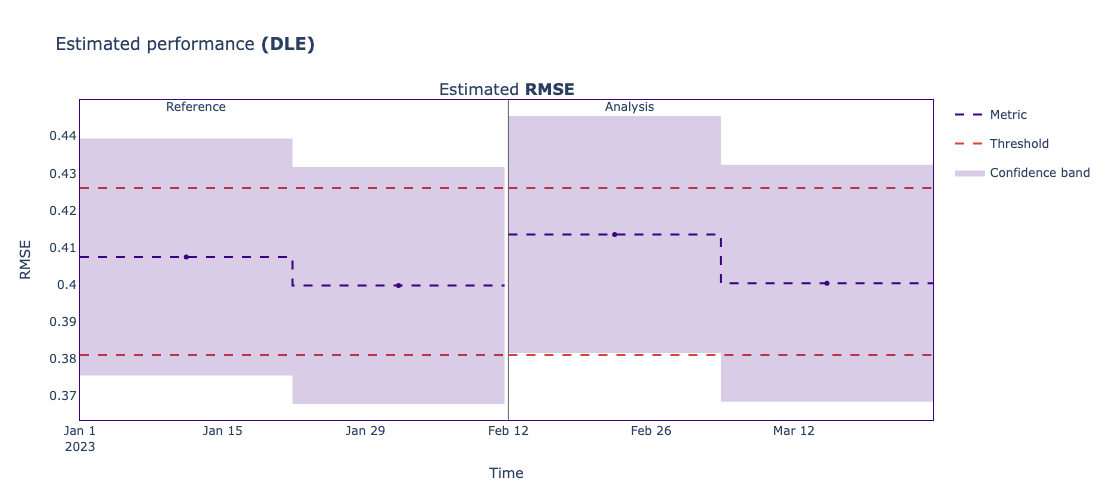

In [9]:
import nannyml as nml
import pandas as pd
import numpy as np

# 1. Simulate Data
# Reference: Model performs well
ref_df = pd.DataFrame({
    "feature1": np.random.rand(1000),
    "y_true": np.random.rand(1000),
    "y_pred": np.random.rand(1000), # Good predictions
    "timestamp": pd.date_range("2023-01-01", periods=1000, freq="h")
})

# Analysis: Feature drift occurs (feature1 becomes larger)
ana_df = pd.DataFrame({
    "feature1": np.random.rand(1000) + 0.5, # DRIFT!
    "y_pred": np.random.rand(1000),
    # We DON'T have y_true yet in production
    "timestamp": pd.date_range("2023-02-12", periods=1000, freq="h")
})

# 2. Estimate Performance (DLE)
print("\n--- NannyML Performance Estimation ---")
# DLE: Direct Loss Estimation (for Regression/Forecasting)
estimator = nml.DLE(
    feature_column_names=['feature1'],
    y_pred='y_pred',
    y_true='y_true',
    timestamp_column_name='timestamp',
    metrics=['rmse'],
    chunk_size=500
)

estimator.fit(ref_df)
estimated_perf = estimator.estimate(ana_df)
res = estimated_perf.to_df()

# We combine the 'chunk' info and the 'rmse' estimates into a flat view
simple_view = pd.concat([
    res['chunk'][['key', 'start_date', 'end_date']],
    res['rmse'][['value', 'upper_confidence_boundary', 'lower_confidence_boundary']]
], axis=1)

print(simple_view.head())

# Plot the estimation
# This visualizes the estimated RMSE rising due to the drift
estimated_perf.plot().show()